# Animate Eddy Trajectories

In [1]:
import h5py
import numpy as np
from scipy.io import netcdf
from matplotlib import pyplot as plt
from matplotlib import animation as anm
from IPython.display import HTML

In [2]:
fpath_eddy = '/gscratch/jisao/mclaret/GL64/Juin_500m/'
f = h5py.File(fpath_eddy + 'eddy_tracks.mat')

# Arrange data into a list of dictionaries
data = f['tracks']            # relevant variables
varnames = list(f['tracks'])  # variable names
ntracks = len(data['x1'])     # number of tracks (should match with length of data in 'x1')

tracks = []                   # initialize list of eddy tracks

# add dictionaries for each variable to the corresponding eddy index (0 - N-1)
for itrack in range(ntracks):
    variables = {var:[] for var in varnames}  # initialize a dictionary with each variable name
    for var in varnames:
        # go through each variable
        if var[0:6] == 'shapes':
            # translate shapes data to list of numpy arrays (one array for each time step)
            coordinates = []                             # initialize list of coordinates
            numSteps = len(f[data[var][itrack,0]][(0)])  # number of timesteps
            # each timestep has its own hdf5 object reference, so append each step to a list
            for step in range(numSteps):
                coords = np.array(f[f[data[var][itrack,0]][(0, step)]])
                coordinates.append(coords)
            variables[var] = coordinates
        else:
            # translate data from hdf5 object reference to numpy array
            variables[var] = np.array(f[data[var][itrack,0]][(0)])
    tracks.append(variables)
    
print('Number of eddies:', len(tracks))

Number of eddies: 43


In [3]:
print(tracks[0]['step'])
print(2. in tracks[0]['step'])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
True


In [4]:
timestep = {n:0 for n in range(24)}
for track in tracks:
    timestep[int(track['step'][0])] += 1

print('Number of eddies that start at each time step:')
for key, value in timestep.items():
    print(key, value)

Number of eddies that start at each time step:
0 0
1 27
2 1
3 0
4 2
5 0
6 3
7 1
8 0
9 3
10 0
11 0
12 1
13 0
14 0
15 2
16 0
17 1
18 0
19 1
20 1
21 0
22 0
23 0


In [5]:
# import file
fpath_temp = '/gscratch/jisao/mclaret/GL64/Juin_Novembre/'
gridT_k1 = netcdf.netcdf_file(fpath_temp + 'GLazur64-T20_y2009m06_m11_gridT_k1.nc','r')

# keep variables
lat = gridT_k1.variables['nav_lat'][:][:].copy()
lon = gridT_k1.variables['nav_lon'][:][:].copy()
land = gridT_k1.variables['votemper'][0][0][:][:].copy()
water = gridT_k1.variables['votemper'][0][0][:][:].copy()
gridT_k1.close()

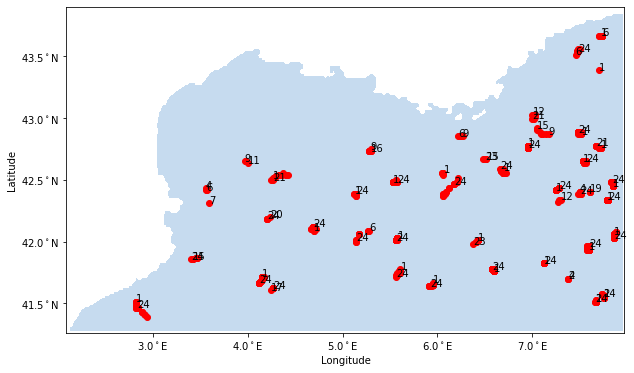

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
land = np.ma.masked_where(land == 0.0, land)
water = np.logical_not(land)

# plot map
plt.contourf(lon, lat, water,cmap='Blues')

# format lat/long labels
locs, labels = plt.xticks()
Elabels = [str(loc) + '$^\circ$E' for loc in locs]
plt.xticks(locs[1:-1], Elabels[1:-1])
locs, labels = plt.yticks()
Nlabels = [str(loc) + '$^\circ$N' for loc in locs]
plt.yticks(locs[1:-1], Nlabels[1:-1])

# figure labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ntracks = len(tracks)  # number of eddies

def animate(i):
    # iterable function to be animated
    xs_scatter = []  # holds x of every point
    ys_scatter = []  # holds y of every point
    for itrack in range(ntracks):
        # check every track
        if tracks[itrack]['step'][0] == i:
            # annotate step if first position
            x = tracks[itrack]['x1'][0]
            y = tracks[itrack]['y1'][0]
            xs_scatter.append(x)
            ys_scatter.append(y)
            ax.annotate(str(i), (x, y))
        elif tracks[itrack]['step'][-1] == i:
            # annotate step if last position
            x = tracks[itrack]['x1'][-1]
            y = tracks[itrack]['y1'][-1]
            xs_scatter.append(x)
            ys_scatter.append(y)
            ax.annotate(str(i), (x, y))
        elif i in tracks[itrack]['step']:
            # plot without annotating
            j = np.where(tracks[itrack]['step'] == i)
            x = tracks[itrack]['x1'][j]
            y = tracks[itrack]['y1'][j]
            xs_scatter.append(x)
            ys_scatter.append(y)
    ax.scatter(xs_scatter, ys_scatter, marker='o', color='r')
    
# frames = num of timesteps, interval = time btwn frames in ms
anim = anm.FuncAnimation(fig, animate, frames = 30, interval = 300)
HTML(anim.to_jshtml())